To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are **surrounding the number of jets that The League needs to own**, and **the cost of fuel for those flights**. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [2]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Explore the data
team_flights = pd.read_csv('data/team_flights.csv')
fuel_prices = pd.read_csv('data/fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

# Number of Jet

## Analysis
How many teams will be simultaneously in flight?
If each team requires a jet, then for identifying the max number of jets we need we should figure out the number of team departing on the same day.

In [3]:
# Group the flight schedule data
flight_period = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])
all_period = sorted(list(set(flight_period)))

In [4]:
# Count the flights number
in_flight_period = pd.DataFrame({'date': all_period, 'in_flight': 0})
for index, flight in team_flights.iterrows():
    in_flight_period.loc[(in_flight_period['date'] >= flight['departure_datetime']) & 
                         (in_flight_period['date'] < flight['landing_datetime']),'in_flight'] += 1

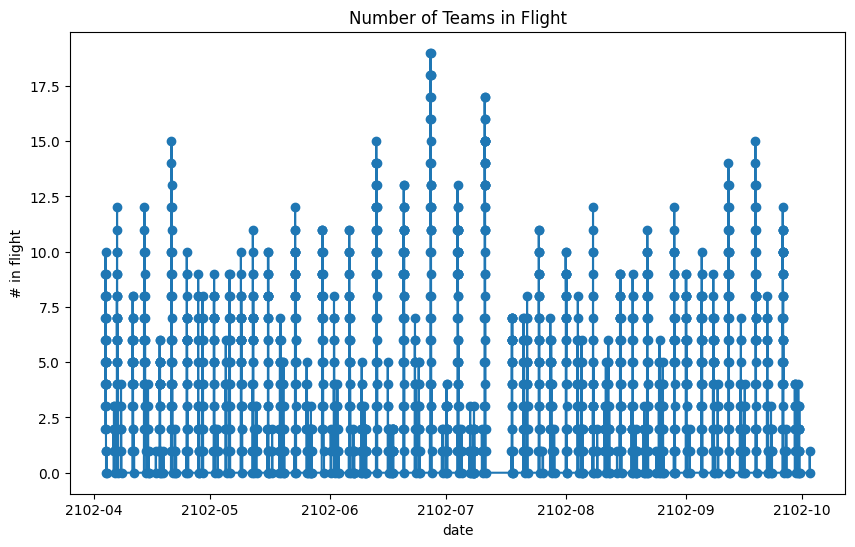

In [5]:
# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.step(in_flight_period['date'], in_flight_period['in_flight'], where='post')
ax.scatter(in_flight_period['date'], in_flight_period['in_flight'])
ax.set_xlabel('date')
ax.set_ylabel('# in flight')
ax.set_title('Number of Teams in Flight')
plt.show()

In [6]:
max_teams_in_flight = in_flight_period['in_flight'].max()
print("Maximum number of jets needed: ", max_teams_in_flight)

Maximum number of jets needed:  19


# Total Fuel Cost

## Analysis
The Office of Transportation would like to know the fuel costs for 2102 to better prepare for the budget plan. With the given fuel price record in 2101, we need to forecast the fuel price of the 2102 to have an idea of the cost.

--> How many gallens of fuel needed per flight?

A: Avg speed = 500 miles / hour.
Total distance for flight = 500 * hr of flight miles

Each flight will fill up with gallon oof fuel same as distance (500 Gallen = 500 miles of flight)

--> **Fuel cost per flight = 500 * flgiht hrs * (fuel price of the departue date)**

In [7]:
# Observe the data, the form of fuel prices time series
fuel_prices

,price
date,
2101-01-01,0.97
2101-01-02,0.87
2101-01-03,0.87
2101-01-04,0.97
2101-01-05,1.10
...,...
2101-12-27,1.33
2101-12-28,1.46
2101-12-29,1.51


Before modelling and forecasting, we need to make sure if the time series is stationary, because a non-stationary time series cannot be modelled as it is variant to time changes. This can be examined through the augmented Dickey-Fuller test.

Augmented Dickey-Fuller Test:
Null hypothesis: The time series is not-stationary (random walk).
Alternative hypothesis: The time series is stationary (not a random walk).

In [8]:
from statsmodels.tsa.stattools import adfuller
adfuller_fuel_prices = adfuller(fuel_prices)

print(f"The p-value is: {adfuller_fuel_prices[1]}, test-statistics: {adfuller_fuel_prices[0]}.")
if adfuller_fuel_prices[1] <= 0.05:
    print("We reject the null hypothesis that the data is non-stationary.")
else:
    print("We cannot reject the null hypothesis that the data is non-stationary.")

The p-value is: 0.9664205149823414, test-statistics: 0.10529145706873937.
We cannot reject the null hypothesis that the data is non-stationary.


The data is obviously not stationary. We will have to do some transformation.

In [9]:
# Take the first and seasonal time series differencing
fuel_prices_diff = fuel_prices.diff().diff(8).dropna()
fuel_prices_diff

,price
date,
2101-01-10,0.11
2101-01-11,0.10
2101-01-12,0.03
2101-01-13,-0.08
2101-01-14,-0.11
...,...
2101-12-27,0.10
2101-12-28,0.03
2101-12-29,-0.08


In [10]:
# Conduct the ADF test after transformation
adfuller_fuel_prices_diff = adfuller(fuel_prices_diff)
print(f"The p-value is: {adfuller_fuel_prices_diff[1]}, test-statistics: {adfuller_fuel_prices_diff[0]}.")
if adfuller_fuel_prices_diff[1] <= 0.05:
    print("We reject the null hypothesis that the data is non-stationary.")
else:
    print("We cannot reject the null hypothesis that the data is non-stationary.")

The p-value is: 8.463576860272219e-08, test-statistics: -6.129624165069191.
We reject the null hypothesis that the data is non-stationary.


The transformed data is now stationary. It's ready to model now.

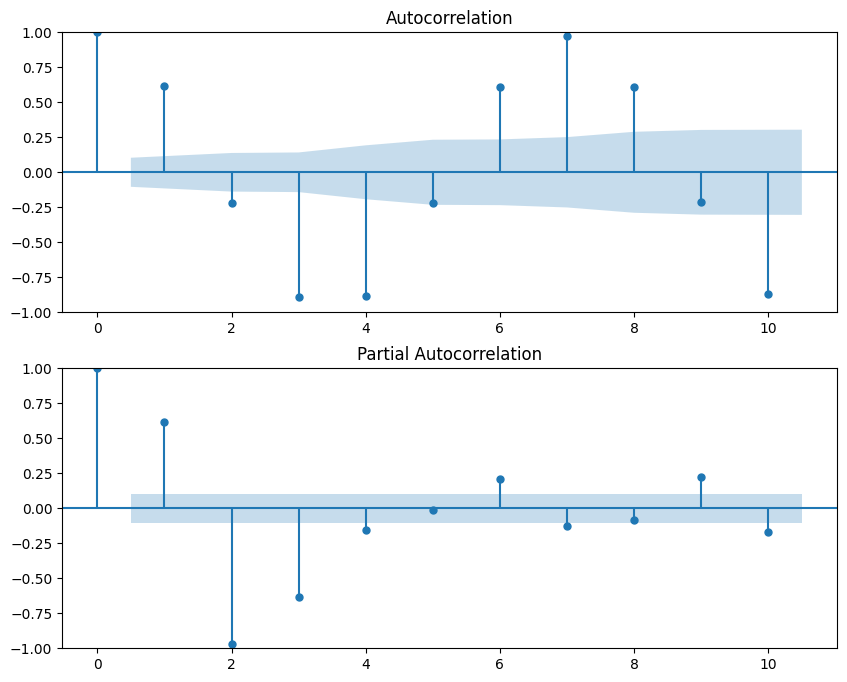

In [11]:
# Find the first SARIMA ORDER
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(fuel_prices_diff, lags=10, zero=True, ax=ax1)
plot_pacf(fuel_prices_diff, lags=10, zero=True, ax=ax2)
plt.show()

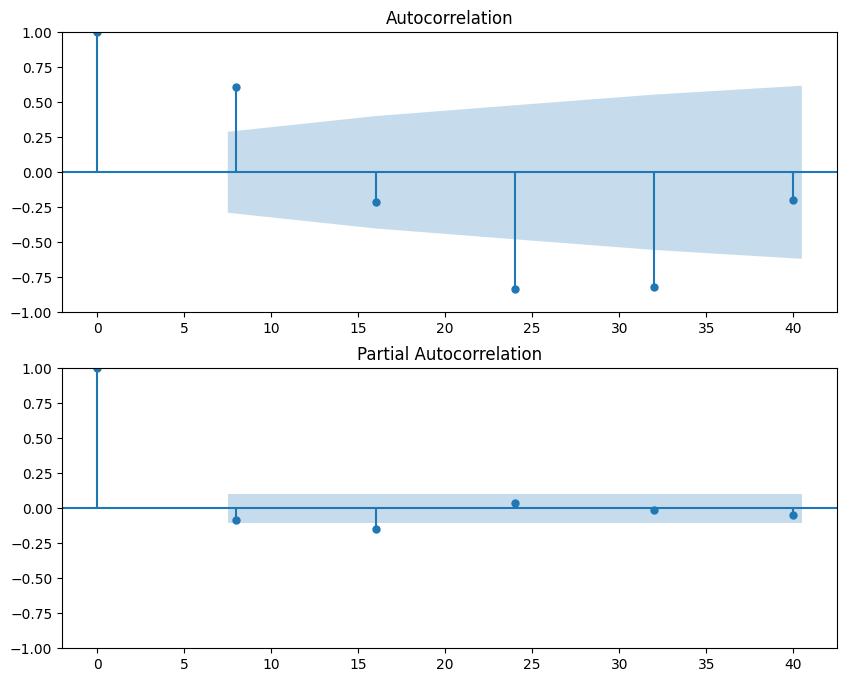

In [12]:
# Find the seasonal order SARIMA
lags = [8 * i for i in range(0, 6)]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(fuel_prices_diff, lags=lags, zero=True, ax=ax1)
plot_pacf(fuel_prices_diff, lags=lags, zero=True, ax=ax2)
plt.show()

In [13]:
# Try to get the best params for SARIMA model
# import pmdarima as pm
# model = pm.auto_arima(fuel_prices,
#                      seasonal=True, m=7,
#                      d=1, D=1,
#                      start_q=3, max_p=2, max_q=4,
#                      start_P=1, max_P=3, max_Q=3,
#                      information_criterion='aic',
#                      trace=True,
#                      error_action='ignore')
# print(model)
# Best model order = (2,1,2)(0,1,1)[8]

## From the auto ARIMA function we got that the best model order (with the lowest AIC) is (2,1,2)(0,1,1)[8]

In [25]:
# Build the model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(fuel_prices, order=(2,1,2), seasonal_order=(0,1,1,8))
result = model.fit()
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               price   No. Observations:                  365
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 8)   Log Likelihood                1409.870
Date:                             Fri, 15 Aug 2025   AIC                          -2807.740
Time:                                     20:28:36   BIC                          -2784.490
Sample:                                 01-01-2101   HQIC                         -2798.492
                                      - 12-31-2101                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2451      0.002    731.576      0.000       1.242       1.248
ar.L2         -0.9972      

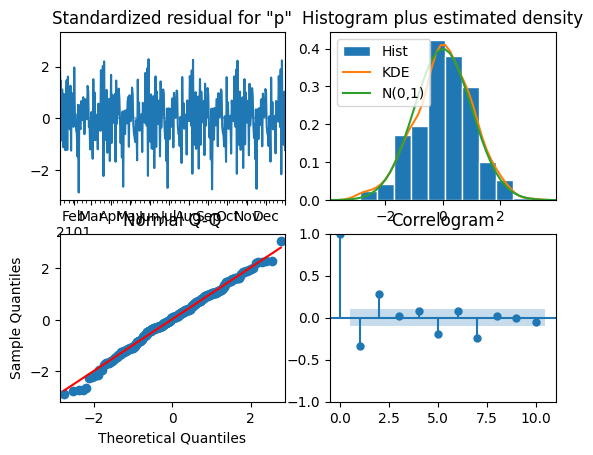

In [26]:
# Plot the diagnostics model to see if the model fits
result.plot_diagnostics()
plt.show()

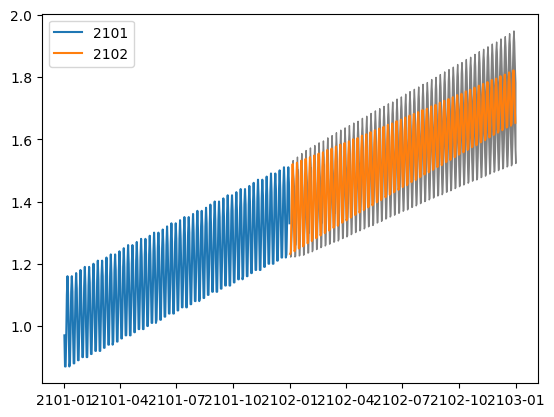

In [27]:
# Plot the forecast
fuel_prices_forecast = result.get_forecast(steps=365)
forecast_mean = fuel_prices_forecast.predicted_mean
forecast_conf_int = fuel_prices_forecast.conf_int()

# Plot
plt.plot(fuel_prices.index, fuel_prices['price'], label='2101')
plt.plot(forecast_mean.index, forecast_mean, label='2102')
plt.fill_between(forecast_mean.index, forecast_conf_int['lower price'], forecast_conf_int['upper price'], color='grey')
plt.legend(loc='upper left')
plt.show()

In [28]:
# Combine the forecasted prices with team flights
team_flights['departure_date'] = pd.to_datetime(team_flights['departure_datetime']).dt.date
forecast_mean.index = pd.to_datetime(forecast_mean.index).date
flights_fuel_prices = team_flights.merge(forecast_mean, how='left', left_on='departure_date', right_on=forecast_mean.index)

In [29]:
# Calculate the total fuel prices per flight and sum it up
flights_fuel_prices['fuel_price'] = flights_fuel_prices['travel_distance_miles'] * flights_fuel_prices['predicted_mean']
total_fuel_spend_2102_dollars = flights_fuel_prices['fuel_price'].sum()
print("Total fuel prices for 2102:", round(total_fuel_spend_2102_dollars, 1))

Total fuel prices for 2102: 1871227.5


SARIMA(1,1,1)(1,0,0)[7] predicted total prices = 1858731.3 (Official Solution)

SARIMA(2,1,2)(0,1,1)[8] predicted total prices = 1871227.5